In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import boto3
import os

from models import MobileNetV3, ViT
from data_preparation import CreateDataset, load_images_and_labels, encode_labels, create_data_augmentation
from trainer import evaluate_model, plot_losses
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import multiprocessing

num_workers = multiprocessing.cpu_count()

batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_num_threads(num_workers)

print(f"Using {num_workers} CPU cores for training")
print(f"Device is {device}")

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using 32 CPU cores for training
Device is cuda


In [2]:
data = "fer2013"

bucket_name = 'thesissagemakerbucket'
train_path = f'{data}/train'
test_path = f'{data}/test'

X_train, y_train = load_images_and_labels(bucket_name, train_path)
X_test, y_test = load_images_and_labels(bucket_name, test_path)

In [3]:
X = X_train + X_test
y = y_train + y_test

# split into training and testing data using sklearn
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test_and_val,
                                                y_test_and_val,
                                                test_size=0.5,
                                                random_state=42)

In [4]:
# Encode labels to integers
label_encoder, y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)

In [5]:
transform = create_data_augmentation()

train_dataset = CreateDataset(X_train, y_train, transform=transform)
test_dataset = CreateDataset(X_test, y_test, transform=transform)
val_dataset = CreateDataset(X_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [6]:
teacher_model = ViT(num_labels=len(label_encoder.classes_))

model_path = f'vit_{data}_best_model.pt'

teacher_model.load_state_dict(torch.load(model_path, weights_only=False))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [7]:
student_model = MobileNetV3(num_labels=len(label_encoder.classes_))

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# If multiple GPUs are available, use DataParallel
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    teacher_model = torch.nn.DataParallel(teacher_model)
    student_model = torch.nn.DataParallel(student_model)

teacher_model = teacher_model.to(device)
student_model = student_model.to(device)

In [9]:
def train_knowledge_distillation(teacher,
                                 student,
                                 train_loader,
                                 val_loader,
                                 epochs,
                                 learning_rate,
                                 T,
                                 soft_target_loss_weight,
                                 ce_loss_weight,
                                 device,
                                 patience=5):

    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()
    student.train()

    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        student.train()

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher(inputs).logits

            student_logits = student(inputs)

            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            label_loss = ce_loss(student_logits, labels)

            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            del inputs, labels, student_logits, teacher_logits, loss
            torch.cuda.empty_cache()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        student.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)

                student_logits = student(inputs)

                label_loss = ce_loss(student_logits, labels)
                val_loss += label_loss.item()

                # Deleting only the unnecessary variables
                del inputs, labels, student_logits
                torch.cuda.empty_cache()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            #torch.save(student.state_dict(), f'model/student_{data}_best_model.pt')
            best_model = student
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    return best_model, train_losses, val_losses


best_model, train_loss, val_loss = train_knowledge_distillation(teacher=teacher_model,
                                            student=student_model,
                                            train_loader=train_loader,
                                            val_loader=test_loader,
                                            epochs=500,
                                            learning_rate=0.0001,
                                            T=8,
                                            soft_target_loss_weight=0.25,
                                            ce_loss_weight=0.75,
                                            device=device,
                                            patience=5
                                        )

Epoch 1/500 - Validation: 100%|██████████| 71/71 [00:17<00:00,  4.15it/s]


Epoch 1/500, Train Loss: 2.0313, Validation Loss: 1.6285


Epoch 2/500 - Validation: 100%|██████████| 71/71 [00:16<00:00,  4.25it/s]


Epoch 2/500, Train Loss: 1.6217, Validation Loss: 1.3769


Epoch 3/500 - Validation: 100%|██████████| 71/71 [00:17<00:00,  4.16it/s]


Epoch 3/500, Train Loss: 1.4684, Validation Loss: 1.2924


Epoch 4/500 - Validation: 100%|██████████| 71/71 [00:17<00:00,  4.17it/s]


Epoch 4/500, Train Loss: 1.3835, Validation Loss: 1.2360


Epoch 5/500 - Validation: 100%|██████████| 71/71 [00:15<00:00,  4.46it/s]


Epoch 5/500, Train Loss: 1.3253, Validation Loss: 1.1822


Epoch 6/500 - Validation: 100%|██████████| 71/71 [00:15<00:00,  4.52it/s]


Epoch 6/500, Train Loss: 1.2639, Validation Loss: 1.1477


Epoch 7/500 - Validation: 100%|██████████| 71/71 [00:15<00:00,  4.45it/s]


Epoch 7/500, Train Loss: 1.2243, Validation Loss: 1.1333


Epoch 8/500 - Validation: 100%|██████████| 71/71 [00:15<00:00,  4.49it/s]


Epoch 8/500, Train Loss: 1.1873, Validation Loss: 1.1149


Epoch 9/500 - Validation: 100%|██████████| 71/71 [00:15<00:00,  4.57it/s]


Epoch 9/500, Train Loss: 1.1525, Validation Loss: 1.0889


Epoch 10/500 - Validation: 100%|██████████| 71/71 [00:16<00:00,  4.30it/s]


Epoch 10/500, Train Loss: 1.1325, Validation Loss: 1.0977


Epoch 11/500 - Validation: 100%|██████████| 71/71 [00:15<00:00,  4.62it/s]


Epoch 11/500, Train Loss: 1.1010, Validation Loss: 1.0971


Epoch 12/500 - Validation: 100%|██████████| 71/71 [00:16<00:00,  4.40it/s]


Epoch 12/500, Train Loss: 1.0738, Validation Loss: 1.0860


Epoch 13/500 - Validation: 100%|██████████| 71/71 [00:15<00:00,  4.44it/s]


Epoch 13/500, Train Loss: 1.0460, Validation Loss: 1.0534


Epoch 14/500 - Validation: 100%|██████████| 71/71 [00:15<00:00,  4.48it/s]


Epoch 14/500, Train Loss: 1.0295, Validation Loss: 1.0635


Epoch 15/500 - Validation: 100%|██████████| 71/71 [00:16<00:00,  4.44it/s]


Epoch 15/500, Train Loss: 1.0079, Validation Loss: 1.0647


Epoch 16/500 - Validation: 100%|██████████| 71/71 [00:16<00:00,  4.36it/s]


Epoch 16/500, Train Loss: 0.9879, Validation Loss: 1.0611


Epoch 17/500 - Validation: 100%|██████████| 71/71 [00:16<00:00,  4.28it/s]


Epoch 17/500, Train Loss: 0.9660, Validation Loss: 1.0558


Epoch 18/500 - Validation: 100%|██████████| 71/71 [00:16<00:00,  4.30it/s]


Epoch 18/500, Train Loss: 0.9446, Validation Loss: 1.0537


Epoch 19/500 - Validation: 100%|██████████| 71/71 [00:16<00:00,  4.28it/s]


Epoch 19/500, Train Loss: 0.9269, Validation Loss: 1.0545


Epoch 20/500 - Validation: 100%|██████████| 71/71 [00:17<00:00,  4.14it/s]


Epoch 20/500, Train Loss: 0.9054, Validation Loss: 1.0678


Epoch 21/500 - Validation: 100%|██████████| 71/71 [00:16<00:00,  4.38it/s]


Epoch 21/500, Train Loss: 0.8943, Validation Loss: 1.0718


Epoch 22/500 - Validation: 100%|██████████| 71/71 [00:16<00:00,  4.33it/s]


Epoch 22/500, Train Loss: 0.8747, Validation Loss: 1.0644


Epoch 23/500 - Validation: 100%|██████████| 71/71 [00:16<00:00,  4.25it/s]

Epoch 23/500, Train Loss: 0.8551, Validation Loss: 1.0663
Early stopping triggered after 23 epochs.


In [10]:
# Save the model to a local path
model_dir = f'{data}/models'

model_path = f'distilled_model_{data}_best_model.pt'
torch.save(best_model.state_dict(), model_path)

# Upload the model to S3
s3 = boto3.client('s3')
s3.upload_file(model_path, bucket_name, os.path.join(model_dir, model_path))

os.remove(model_path)

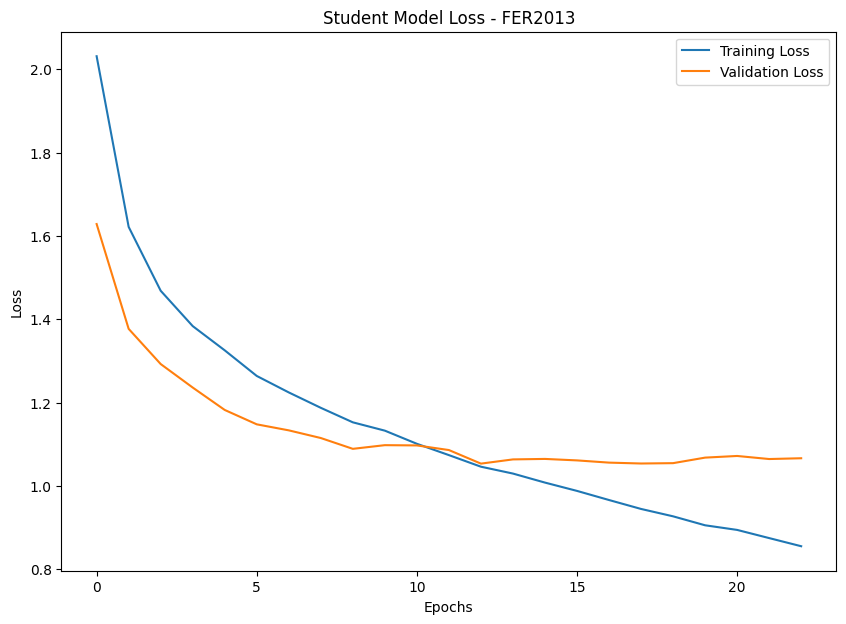

In [11]:
plot_losses(train_loss, val_loss, f'Student Model Loss - {data.upper()}')

In [12]:
best_model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

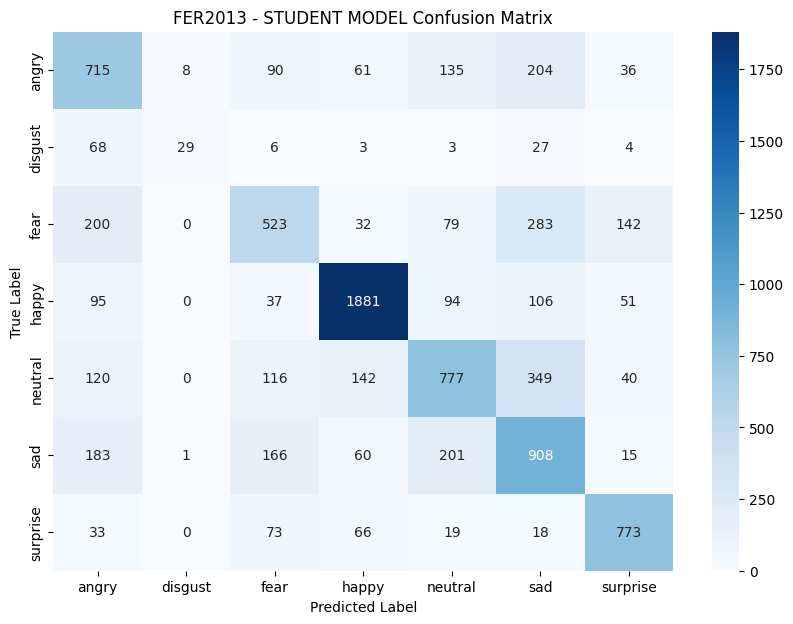

Test Accuracy: 0.6248
Precision: 0.6322
Recall: 0.5583
F1 Score: 0.5699
Classification Report:
               precision    recall  f1-score   support

       angry       0.51      0.57      0.54      1249
     disgust       0.76      0.21      0.33       140
        fear       0.52      0.42      0.46      1259
       happy       0.84      0.83      0.83      2264
     neutral       0.59      0.50      0.54      1544
         sad       0.48      0.59      0.53      1534
    surprise       0.73      0.79      0.76       982

    accuracy                           0.62      8972
   macro avg       0.63      0.56      0.57      8972
weighted avg       0.63      0.62      0.62      8972



In [13]:
evaluate_model(best_model, 
               test_loader, 
               device, 
               data.upper()+" - Student Model",
               label_encoder=label_encoder)